(optional)

In [141]:
from google.colab import drive
#import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ML_HW/HW5')
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['hw5_template.ipynb',
 'data.npz',
 'label.npz',
 'lstm_output.csv',
 'eegnet_output.csv',
 'competition_output.csv']

# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [168]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here

In [169]:
data = np.load('data.npz')
label = np.load('label.npz')

In [170]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

In [171]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [172]:
X_train = X_train.reshape(-1, 200, 22)
X_val = X_val.reshape(-1, 200, 22)
X_test = X_test.reshape(-1, 200, 22)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(604, 200, 22)
(152, 200, 22)
(190, 200, 22)


In [173]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

In [174]:
Y_train = np.eye(6)[Y_train.astype(int)].reshape(604,6)
Y_val = np.eye(6)[Y_val.astype(int)].reshape(152,6)

In [175]:
print(Y_train.shape)

(604, 6)


## Model Implementation Part

### LSTM

In [176]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [177]:
# Build your model here:
model = keras.Sequential()
model.add(layers.LSTM(48, input_shape = (200, 22), return_sequences=True))#
model.add(layers.Flatten())
model.add(layers.Dense(6, activation='softmax'))
model.build()
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 200, 48)           13632     
                                                                 
 flatten_23 (Flatten)        (None, 9600)              0         
                                                                 
 dense_23 (Dense)            (None, 6)                 57606     
                                                                 
Total params: 71,238
Trainable params: 71,238
Non-trainable params: 0
_________________________________________________________________


In [178]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])#

history = model.fit(X_train, Y_train, epochs = 30, validation_data = (X_val, Y_val))

Epoch 1/30
19/19 [==============================] - 3s 53ms/step - loss: 0.8809 - accuracy: 0.7020 - val_loss: 0.3294 - val_accuracy: 0.9079
Epoch 2/30
19/19 [==============================] - 0s 19ms/step - loss: 0.0773 - accuracy: 0.9917 - val_loss: 0.2357 - val_accuracy: 0.8947
Epoch 3/30
19/19 [==============================] - 0s 18ms/step - loss: 0.0246 - accuracy: 1.0000 - val_loss: 0.1449 - val_accuracy: 0.9539
Epoch 4/30
19/19 [==============================] - 0s 13ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.1485 - val_accuracy: 0.9474
Epoch 5/30
19/19 [==============================] - 0s 12ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.1387 - val_accuracy: 0.9474
Epoch 6/30
19/19 [==============================] - 0s 12ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.1317 - val_accuracy: 0.9605
Epoch 7/30
19/19 [==============================] - 0s 12ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.1274 - val_accuracy: 0.9605
Epoch 8/30
19

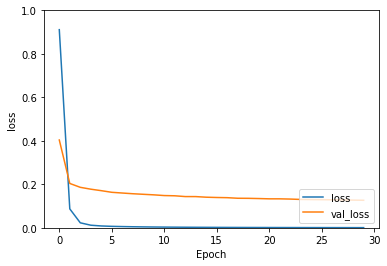

In [153]:
#plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [154]:
pred_test = model.predict(X_test)

6/6 [==============================] - 0s 5ms/step


In [155]:
pred = np.argmax(pred_test, axis = 1).reshape(-1, 1)

In [156]:
output = pred
assert(output.shape == (190, 1))
np.savetxt('lstm_output.csv', output, delimiter=",")

### EEGNet

In [157]:
X_train.shape, X_val.shape, X_test.shape

((604, 200, 22), (152, 200, 22), (190, 200, 22))

In [158]:
X_train = X_train.reshape(-1, 1, 22, 200)
X_val = X_val.reshape(-1, 1, 22, 200)
X_test = X_test.reshape(-1, 1, 22, 200)

In [159]:
X_train.shape, X_val.shape, X_test.shape

((604, 1, 22, 200), (152, 1, 22, 200), (190, 1, 22, 200))

In [160]:
Y_train.shape, Y_val.shape

((604, 6), (152, 6))

In [161]:
# Build your model here:
F1 = 10
F2 = 8
D = 2
C = 22
T = 200
model = keras.Sequential()
model.add(layers.Conv2D(filters = F1, kernel_size = (1, 64), input_shape = (1, C, T), 
                        data_format = 'channels_first', activation = 'linear', padding = 'same', use_bias = False))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D(kernel_size = (C, 1), data_format = 'channels_first',
                        depth_multiplier = D, padding = 'valid', activation = 'linear', use_bias = False))
model.add(layers.BatchNormalization())
model.add(layers.Activation('elu'))
model.add(layers.AveragePooling2D((1, 4), data_format = 'channels_first'))
model.add(layers.Dropout(0.25))

model.add(layers.SeparableConv2D(filters = F2, kernel_size = (1, 16), use_bias = False,
                        data_format = 'channels_first', activation = 'linear', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('elu'))
model.add(layers.AveragePooling2D((1, 8), data_format = 'channels_first'))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(6, activation='softmax', use_bias = False))

model.build()
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 10, 22, 200)       640       
                                                                 
 batch_normalization_45 (Bat  (None, 10, 22, 200)      800       
 chNormalization)                                                
                                                                 
 depthwise_conv2d_15 (Depthw  (None, 20, 1, 200)       440       
 iseConv2D)                                                      
                                                                 
 batch_normalization_46 (Bat  (None, 20, 1, 200)       800       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 20, 1, 200)        0         
                                                     

In [162]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])#

history = model.fit(X_train, Y_train, epochs = 40, validation_data = (X_val, Y_val))

Epoch 1/40
19/19 [==============================] - 1s 17ms/step - loss: 1.6751 - accuracy: 0.2798 - val_loss: 1.6263 - val_accuracy: 0.5329
Epoch 2/40
19/19 [==============================] - 0s 8ms/step - loss: 1.3789 - accuracy: 0.4735 - val_loss: 1.5435 - val_accuracy: 0.6645
Epoch 3/40
19/19 [==============================] - 0s 7ms/step - loss: 1.1668 - accuracy: 0.6192 - val_loss: 1.4531 - val_accuracy: 0.7697
Epoch 4/40
19/19 [==============================] - 0s 7ms/step - loss: 0.9108 - accuracy: 0.7566 - val_loss: 1.3120 - val_accuracy: 0.8289
Epoch 5/40
19/19 [==============================] - 0s 7ms/step - loss: 0.7406 - accuracy: 0.7997 - val_loss: 1.1770 - val_accuracy: 0.8553
Epoch 6/40
19/19 [==============================] - 0s 7ms/step - loss: 0.5973 - accuracy: 0.8891 - val_loss: 1.0527 - val_accuracy: 0.9145
Epoch 7/40
19/19 [==============================] - 0s 7ms/step - loss: 0.5055 - accuracy: 0.8974 - val_loss: 0.9047 - val_accuracy: 0.9276
Epoch 8/40
19/19 [=

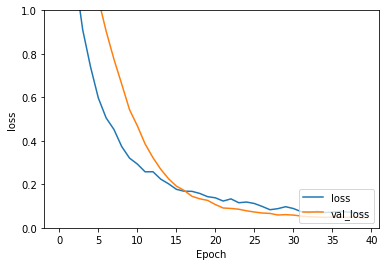

In [163]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [164]:
pred_test = model.predict(X_test)
pred = np.argmax(pred_test, axis = 1).reshape(-1, 1)

6/6 [==============================] - 0s 3ms/step


In [165]:
output = pred
assert(output.shape == (190, 1))
np.savetxt('eegnet_output.csv', output, delimiter=",")

## Model Competition Part

In [166]:
# Build your model here:
# I directly use EEGNet's predictions

In [167]:
output = pred
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, delimiter=",")